# Comment créer un fond de carte à partir de rasters d'altitude et un hillshade

Vous souhaitez faire une carte en javascript ou en python. Rien de plus facile aujourd'hui grâce à **d3.js**. Mais pourquoi pas la pimper un peu avec un fond de carte des reliefs ?

Python permet notamment d'industrialiser facilement ce type de processus.

Un long voyage nous attend, avec quelques challenges :

- récupérer les raster d'altitude
- les fusionner au besoin
- adapter leur projection au besoin de notre carte JavsScript
- appliquer un mask au moment de l'export pour ne garder que la partie en rapport avec notre carte

> Ce tutoriel s'appuie en grande partie sur celui-ci d'[Adam Symington](https://pythonmaps.medium.com/?source=post_page-----efced5507aa3--------------------------------) : [Creating Beautiful Topography Maps with Python](https://towardsdatascience.com/creating-beautiful-topography-maps-with-python-efced5507aa3)


## Installation et chargement des librairies

- Geopandas pour manipuler des GeoDataframes
- rasterio pour la partie raster
- earthpy pour créer des hillshades à partir des raster
- pynsee pour récupérer le découpage administratif de la France


In [ ]:
!pip install geopandas "pynsee[full]" rasterio earthpy scipy matplotlib pandas numpy

In [47]:
import geopandas as gpd
from pynsee.geodata import get_geodata
from matplotlib import pyplot as plt
from pathlib import Path
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from shapely.geometry import mapping
from rasterio import mask as msk
import earthpy.spatial as es
from matplotlib import colors
from pathlib import Path

## Merge des raster

Pour récupérer nos tif d'altitude, allons sur [`topotools`](https://topotools.cr.usgs.gov/gmted_viewer/viewer.htm).  
On peut y récupérer des raster d'altitude à différentes résolutions. Ici on va télécharger manuellement les 4 zones qui contiennent la France métropolitaine.

Pour chacune des zones, il faut prendre le fichier suivant `Mean - 15 arc-sec`. Il y a d'autres résolutions disponibles, mais celle-ci est suffisante pour notre usage.

On ajoute les 4 fichiers dans le dossier `data-ext/topotools` depuis la racine du projet.


On liste d'abord les fichiers


In [4]:
tiff_files = [str(t) for t in Path("../data-ext/topotools/").glob("*.tif")]
tiff_files

['../data-ext/topotools/30N000E_20101117_gmted_mea150.tif',
 '../data-ext/topotools/30N030W_20101117_gmted_mea150.tif',
 '../data-ext/topotools/50N030W_20101117_gmted_mea150.tif',
 '../data-ext/topotools/50N000E_20101117_gmted_mea150.tif']

Faisons une fonction pour afficher un raster avec matplotlib :


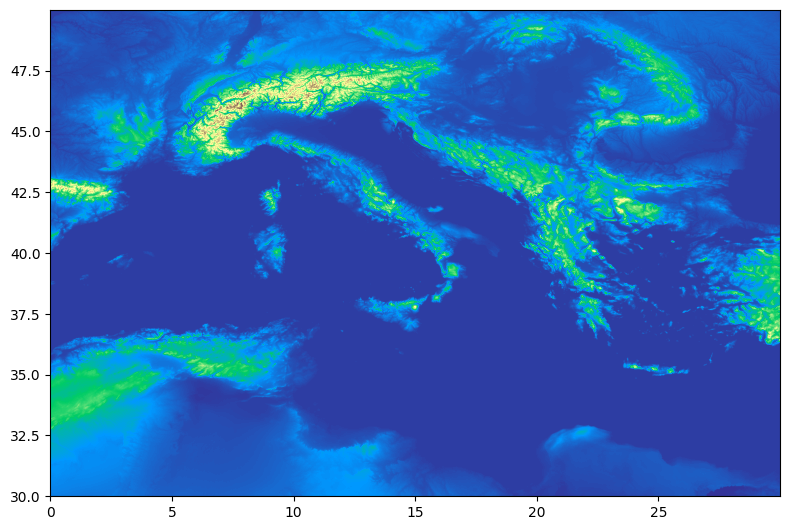

In [5]:
def display_raster(raster):
    fig, ax = plt.subplots(figsize=(8, 8))
    show(raster, ax=ax, cmap="terrain")
    plt.tight_layout()


display_raster(rasterio.open(tiff_files[0]))

Vérifions la projection utilisée :


In [6]:
# which CRS are we using?
rasterio.open(tiff_files[0]).crs

CRS.from_epsg(4326)

On va maintenant pouvoir fusionner nos fichiers :

- On ouvre les raster un à un et on les stocke dans une liste
- On utilise la fonction merge de rasterio pour les fusionner
- On écrit le résultat dans un nouveau fichier en mettant à jour les métadonnées, notamment la projection et la taille
- On sauvegarde le résultat dans le répertoire courant


In [7]:
src_files_to_mosaic = []
for f in tiff_files:
    src = rasterio.open(f)
    src_files_to_mosaic.append(src)

mosaic, out_trans = merge(src_files_to_mosaic)

out_meta = src.meta.copy()
out_meta.update(
    {
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        "crs": "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs",
    }
)
with rasterio.open("mosaic.tiff", "w", **out_meta) as dest:
    dest.write(mosaic)

Regardons le résultat :


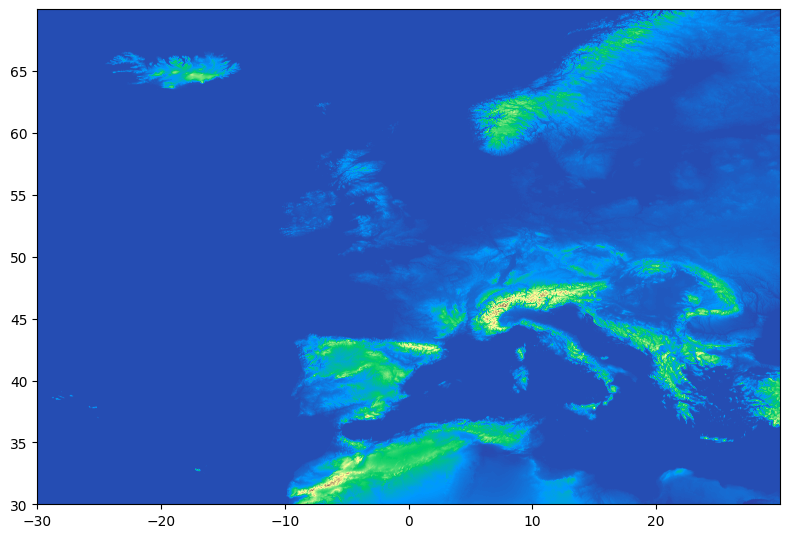

In [8]:
display_raster(rasterio.open("mosaic.tiff"))

## Reprojection

Pour notre carte en javascript, on va utiliser la projection Lambert 93. On va donc adapter notre raster à cette projection :


In [9]:
dst_crs = "EPSG:2154"

with rasterio.open("mosaic.tiff") as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    kwargs = src.meta.copy()
    kwargs.update(
        {"crs": dst_crs, "transform": transform, "width": width, "height": height}
    )

    with rasterio.open("mosaic_reproj.tiff", "w", **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest,
            )

## Clip

On va maintenant découper notre raster pour ne garder que la France métropolitaine. Pour cela, on va utiliser le découpage administratif de l'INSEE. Pour ce faire, on utilise la librairie pynsee pour récupérer le découpage administratif de la France métropolitaine.


- On récupère les départements de la France métropolitaine
- On les transforme en GeoDataFrame (pynsee utiise une version custom des GeoDataFrame)
- On set la projection (qui est initialement en EPSG:3857)
- On reprojette en Lambert 93

On va également dissoudre les départements pour n'en faire qu'un seul contour de la France métropolitaine.


<Axes: >

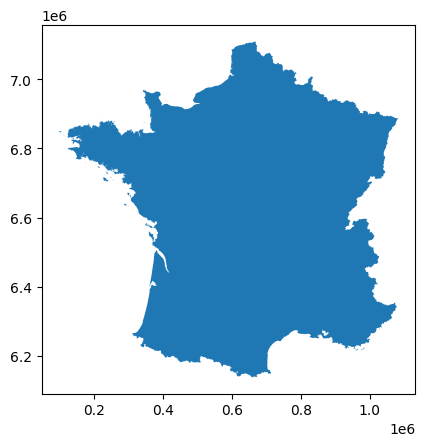

In [10]:
departements = (
    get_geodata("ADMINEXPRESS-COG-CARTO.LATEST:departement")
    .loc[
        lambda x: ~(x["insee_dep"].str.startswith("97"))
        & ~(x["insee_dep"].isin(["2A", "2B"]))
    ]
    .pipe(gpd.GeoDataFrame)
    .set_crs("EPSG:3857")
    .to_crs(dst_crs)
)

france = departements.dissolve()
france.plot()

On clip le raster avec le GeoDataFrame de la France métropolitaine :


In [52]:
raster_full = rasterio.open("mosaic_reproj.tiff")
clipped_array, clipped_transform = msk.mask(
    raster_full, [mapping(france.iloc[0].geometry)], crop=True
)

out_meta = raster_full.meta.copy()
out_meta.update(
    {
        "driver": "GTiff",
        "height": clipped_array.shape[1],
        "width": clipped_array.shape[2],
        "transform": clipped_transform,
        "crs": dst_crs,
    }
)
with rasterio.open("mosaic_reproj_clip.tiff", "w", **out_meta) as dest:
    dest.write(clipped_array)

Voilà le résultat :


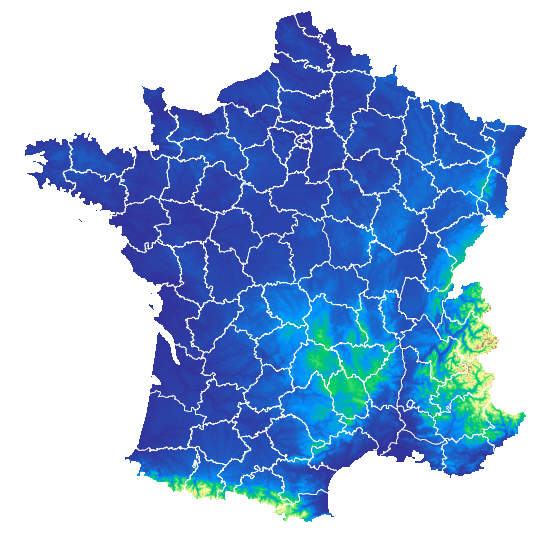

In [53]:
fig, ax = plt.subplots(figsize=(6, 6))
show(rasterio.open("mosaic_reproj_clip.tiff"), ax=ax, cmap="terrain")
(departements.to_crs(dst_crs).plot(ax=ax, facecolor="none", edgecolor="white", lw=0.5))
plt.tight_layout()
ax.set_axis_off()

## Hillshade

On va maintenant créer un hillshade à partir de notre raster. Pour cela, on utilise la librairie earthpy.
Pour les paramètres, j'ai choisi un facteur d'altitude de 10 et une azimut à 180°. Complètement au hasard, le mieux est de tester plusieurs combinaisons.

On utilise un mask pour ne pas conserver les valeurs nulles du raster.


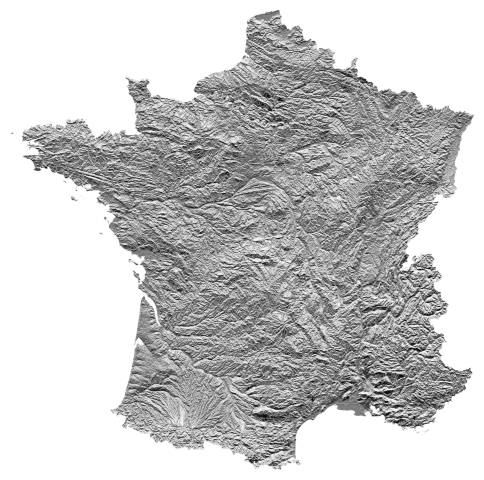

In [12]:
# on calcule le hillshade avec du blanc quand non défini
hillshade = es.hillshade(
    rasterio.open("mosaic_reproj_clip.tiff").read()[0], azimuth=180, altitude=10
)

# on fait un masque avec les valeurs non définies
mask = rasterio.open("mosaic_reproj_clip.tiff").read_masks(1)
hillshade[mask == 0] = 0


fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(hillshade, cmap="Greys")
ax.set_axis_off()

## Génération de la carte

Le plus dur est fait :

- On a un raster d'altitude adapté à notre carte et, à la bonne projection et clipé sur la France métropolitaine
- Un hillshade qui va nous permettre de donner du relief à notre carte

On mélange tout ça avec matplotlib pour créer notre carte avec :

- Le raster d'altitude en fond
- Le hillshade en dessus et un effet de transparence

Pour la gestion des couleurs, on utilise un colormap de matplotlib. Là aussi, il faut tester plusieurs combinaisons pour trouver celle qui nous convient le mieux.


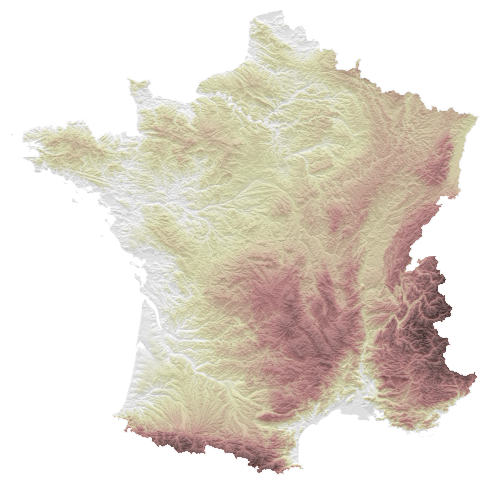

In [59]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
# background white
ax.set_facecolor("white")


i = plt.imshow(
    rasterio.open("mosaic_reproj_clip.tiff").read()[0],
    cmap="pink_r",
    # on normalise log pour avoir une meilleure dynamique, avec un min à 40m
    norm=colors.LogNorm(vmin=40, vmax=3500, clip=True),
    alpha=1,
)

ax.imshow(hillshade, cmap="Greys", alpha=0.25)

ax.set_axis_off()
plt.tight_layout()

# no margin when we save
output_dir = Path("../public/")
output_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(output_dir / "elevation.jpeg", bbox_inches="tight", pad_inches=0, dpi=200)

On sauvegarde aussi nos départements en GeoJSON pour pouvoir les afficher sur notre carte.


In [61]:
departements.to_crs("EPSG:4326").simplify(0.01).to_file(
    output_dir / "departements.geojson", driver="GeoJSON"
)